In [6]:
import pyodbc
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import math
from contextlib import contextmanager
from datetime import date, timedelta
from IPython.display import display, Markdown, HTML
from statsmodels.nonparametric.smoothers_lowess import lowess



import sys
sys.path.append('../lib/')
from functions import *
sys.path.append('../analysis/')
from config import date_cols 

# get data extraction date
extract_date = pd.to_datetime(os.path.getmtime("../output/input.feather"), unit='s')
# get notebook run date
run_date = date.today()

# COVID-19 identification in primary care records from Feb 2020- November 2021: classification of codes for OpenSAFELY studies

## Background

Primary care records offer an opportunity to ascertain cases of COVID-19 which do not necessarily result in hospital admission or death. This could be useful for studying the burden of COVID-19 in the community, risk factors for SARS-CoV-2 infection separately to risk of severe COVID-19, risk factors for mortality and case fatality ratios among those infected, and post-viral effects in people who had COVID-19 that did not require hospitalisation. 

There are over 100 primary care (CTV3) codes with terms related to COVID-19 used by TPP and available for selection in studies performed in the OpenSAFELY platform (https://opensafely.org/).  The majority of these codes have been newly created for use in the current pandemic. The aim of this work was to assign these codes into categories related to the identification of COVID-19 in primary care, and to provide advice for studies using the OpenSAFELY platform that require people to be classified by their COVID-19 case status as defined in primary care records (either as an exposure or as an outcome).

## Methods

An initial list of TPP primary care codes related to COVID-19 was obtained by searching the TPP database for terms containing "COV-2", "Coronavirus", or "COVID". The returned terms were cross-checked against the NHS Digital [COVID-19 SNOMED CT codes](https://hscic.kahootz.com/connect.ti/COVID19_info_sharing/view?objectId=67227941) and CTV3 codes for any missing terms which were added to the list when found.  The resulting list of terms was then reviewed by a team of clinicians, epidemiologists and statisticians in order to identify distinct categories of terms and assign terms into one of these distinct categories. 

An initial analysis of (probable case and suspected case) sub-categories was then performed by plotting the following using OpenSAFELY data from between February 2020 – November 2021 (1) the frequency of codes entered into TPP software by GPs over time and (2) the proportion of people dying due to (a) COVID-19 and (b) causes other than COVID-19 (using ONS cause of death data) in the 80 days after a record of a positive test in either primary care TPP data or in SGSS data.



## Results

A total of 187 terms were identified. These were assigned into the 14 categories/subcategories detailed in the table below. The 14 codelists for classifying COVID-19 are publicly available on OpenSAFELY.org for inspection and re-use [codelists.opensafely.org](https://codelists.opensafely.org/). 



<!--| Category  |  Sub-category (if applicable) |  Description |
|:---|:---|:---|
| Probable case | Clinical code | Clinical diagnosis of COVID-19 made |
|  | Positive test |  Record of positive test result for SARS-CoV-2 (__active infection__) |
|  | Sequelae | Symptom or condition recorded as secondary to SARS-CoV-2 |
| Suspected case | Advice | General advice given about SARS-CoV-2 |
|  | Had test | Record of having had a test for active infection with SARS-CoV-2 |
|  | Isolation code | Self or household-isolation recorded |
|  | Non-sepcific clinical assessment | Clinical assessments plausibly related to COVID-19 |
|  | Suspected codes | "Suspect" mentioned, or previous COVID-19 reported |
| Historic case | - | SARS-CoV-2 antibodies or immunity recorded |
| Potential historic case | - | Has had a test for SARS-CoV-2 antibodies |
| Exposure to disease | - | Record of contact/exposure/procedure |
| Antigen test negative | - | Record of negative test result for SARS-CoV-2 |
| COVID-19 related contact but case status not specified | - | Healthcare contact related to COVID-19 but not case status |
-->

In [7]:
os.getcwd()
styles = [dict(selector="th", props=[("text-align", "left")])]
tabledata = pd.read_csv(f"../output/tabledata.csv")
tabledata = tabledata[["Codelist", "Description", "Count"]].style.set_properties(subset=["Codelist","Description"], **{'text-align':'left', 'index':False}).set_table_styles(styles).hide_index()
display(tabledata)


#without hyperlinks
#tabledata[["Category", "Sub-category" "Description", "Count"]].style.set_properties(subset=["Category","Sub-category","Description"], **{'text-align':'left', 'index':False}).set_table_styles(styles).hide_index()

Codelist,Description,Count
Probable case: clinical code,Clinical diagnosis of COVID-19 made,1814
Probable case: positive test,Record of positive test result for SARS-CoV-2 (active infection),1807
Probable case: sequelae,Symptom or condition recorded as secondary to SARS-CoV-2,1815
Suspected case: advice,General advice given about SARS-CoV-2,1819
Suspected case: had test,Record of having had a test for active infection with SARS-CoV-2,1829
Suspected case: had antigen test,Record of having had an antigen test for infection with SARS-CoV-2,1823
Suspected case: isolation code,Self- or household-isolation recorded,1798
Suspected case: non-specific clinical assessment,Clinical assessments plausibly related to COVID-19,1808
Suspected case: suspected codes,"""Suspect"" mentioned, or previous COVID-19 reported",1817
Historic case,SARS-CoV-2 antibodies or immunity recorded,1842


In [8]:
codecounts_week = pd.read_csv(
    filepath_or_buffer = f"../output/codecounts_week.csv"
)
codecounts_total = codecounts_week.sum()

display(Markdown(f"""
"Probable" and "suspected" sub-categories are explored further here. 
Plots of frequency of codes (Figure 1) showed that the use of "probable case: positive test" (n={codecounts_total["probable_covid_pos_test"]}) was far more frequent than 
"probable case: clinical code" (n={codecounts_total["probable_covid"]}) and "probable case: sequelae" (n={codecounts_total["probable_covid_sequelae"]}) over the study period. 
The use of "probable case: positive test" was less frequent than "SGSS positive test" (n={codecounts_total["sgss_positive_test"]}) but followed a similar distribution. 
Suspected case sub-categories were used much more frequently than "probable case: positive test" - suspected case: "advice given" (n={codecounts_total["suspected_covid_advice"]}),
"isolation code" (n={codecounts_total["suspected_covid_isolation"]}) and "suspected codes" (n={codecounts_total["suspected_covid"]}) (Figure 1). Plots of causes of death after each
 code showed marked differences in the proportion of death due to COVID-19 compared to deaths due to other causes following a positive SGSS test in contrast, COVID-19 deaths were 
 not substantially higher than non-COVID deaths following "probable case: positive test" codes (Figure 2).
"""))


"Probable" and "suspected" sub-categories are explored further here. 
Plots of frequency of codes (Figure 1) showed that the use of "probable case: positive test" (n=1804) was far more frequent than 
"probable case: clinical code" (n=1814) and "probable case: sequelae" (n=1813) over the study period. 
The use of "probable case: positive test" was less frequent than "SGSS positive test" (n=1815) but followed a similar distribution. 
Suspected case sub-categories were used much more frequently than "probable case: positive test" - suspected case: "advice given" (n=1815),
"isolation code" (n=1794) and "suspected codes" (n=1816) (Figure 1). Plots of causes of death after each
 code showed marked differences in the proportion of death due to COVID-19 compared to deaths due to other causes following a positive SGSS test in contrast, COVID-19 deaths were 
 not substantially higher than non-COVID deaths following "probable case: positive test" codes (Figure 2).


## Conclusion

A relatively low level of COVID-19 related mortality in people identified as "probable cases" is consistent with these codes failing to identify the most severe COVID-19 cases with high specificity. "Suspected case" codes were 
initially more widely used but do not seem to identify covid cases and should be used with care.  Further work will include investigating code sensitivity, and understanding how individual patient characteristics relate to the varying probability of being tested.


## Figure 1: Frequency of primary care code use over time.

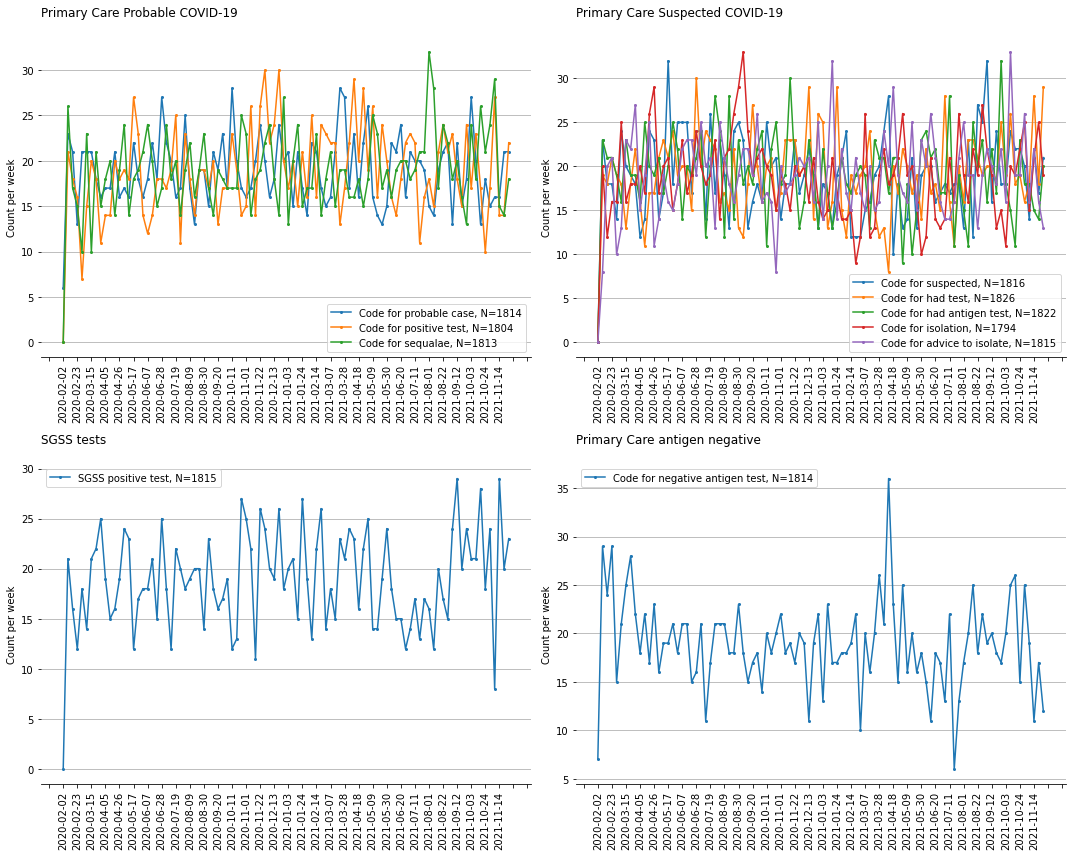

In [9]:
# from IPython.display import SVG
# def show_svg():
#     return SVG(f"../output/plots.svg")
# #
# fig=show_svg()
# fig

#add smoothing
def smooth(df):
    x=df['times'] 
    y1 = df['kmestimate']
    smooth = lowess(y1, x, is_sorted=True, frac=0.025, it=0)
    df['kmestimate'] = smooth[:,1]

codecounts_week = pd.read_csv(
    filepath_or_buffer = f"../output/codecounts_week.csv"
)
codecounts_total = codecounts_week.sum()

#################################### plots 1 ###################################
#################################### plots 1 ###################################
def plotstyle(axesrow, axescol, title):
    axs[axesrow,axescol].set_ylabel('Count per week')
    axs[axesrow,axescol].xaxis.set_tick_params(labelrotation=90)
    loc = ticker.MultipleLocator(base=3.0)
    axs[axesrow,axescol].xaxis.set_major_locator(loc)
    #axs[0,0].set_ylim(bottom=0) # might remove this in future depending on count fluctuation
    axs[axesrow,axescol].grid(axis='y')
    axs[axesrow,axescol].legend()
    axs[axesrow,axescol].set_title(title, loc='left', y=1)
    axs[axesrow,axescol].tick_params(labelbottom=True)
    axs[axesrow,axescol].spines["left"].set_visible(False)
    axs[axesrow,axescol].spines["right"].set_visible(False)
    axs[axesrow,axescol].spines["top"].set_visible(False)
    

fig, axs = plt.subplots(2, 2, figsize=(15,12), sharey=False,  sharex=True)


probable = ['probable_covid', 'probable_covid_pos_test', 'probable_covid_sequelae']
probable_lab=["probable case","positive test","sequalae"]
for i in range(0, len(probable)): 
    axs[0,0].plot(
    codecounts_week["Unnamed: 0"], 
    codecounts_week[probable[i]], 
    marker='o', 
    markersize=2, 
    label=f"""Code for {probable_lab[i]}, N={codecounts_total[probable[i]]}""",
    )


plotstyle(0,0, "Primary Care Probable COVID-19\n");

suspected = ['suspected_covid',
 'suspected_covid_had_test',
 'suspected_covid_had_antigen_test',
 'suspected_covid_isolation',
 'suspected_covid_advice'
 ]

suspected_lab=["suspected",
"had test",
"had antigen test",
"isolation",
"advice to isolate"]
   
for i in range(0, len(suspected)): 
    axs[0,1].plot(
        codecounts_week["Unnamed: 0"], 
        codecounts_week[suspected[i]], 
        marker='o', 
        markersize=2, 
        label=f"""Code for {suspected_lab[i]}, N={codecounts_total[suspected[i]]}""",
        )
plotstyle(0,1, "Primary Care Suspected COVID-19\n");

axs[1,0].plot(
    codecounts_week["Unnamed: 0"], 
    codecounts_week["sgss_positive_test"], 
    marker='o', 
    markersize=2, 
    label=f"""SGSS positive test, N={codecounts_total["sgss_positive_test"]}""",
    )
plotstyle(1,0, "SGSS tests\n");

axs[1,1].plot(
    codecounts_week["Unnamed: 0"], 
    codecounts_week["antigen_negative"], 
    marker='o', 
    markersize=2, 
    label=f"""Code for negative antigen test, N={codecounts_total["antigen_negative"]}""",
    )
axs[1,1].legend()
plotstyle(1,1, "Primary Care antigen negative\n");

plt.tight_layout()

## Figure 2: Comparison of mortality from COVID-19 or other causes in the 80 days following a positive test

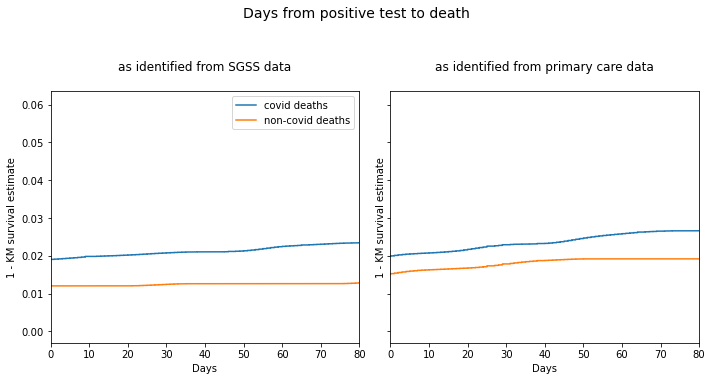

In [10]:
# import data
df = pd.read_feather(
    '../output/input.feather'
)

#derive start/end dates
df["start_date"] = df[date_cols].min().min()
df["end_date"] = df[date_cols].max().max()


# derive time-to-event censoring info

# death date or last date of follow up
df['date_event'] = np.where(df['date_died_ons']<=df['end_date'], df['date_died_ons'], df['end_date'])

# censoring indiators
df['indicator_death'] = np.where((df['date_died_ons']<=df['end_date']) & (df['died_ons']==1), 1, 0)
df['indicator_death_covid'] = np.where((df['date_died_ons']<=df['end_date'])  & (df['died_ons_covid']==1), 1, 0)
df['indicator_death_noncovid'] = np.where((df['date_died_ons']<=df['end_date']) & (df['died_ons_noncovid']==1), 1, 0)

# censor death category if end date exceeds last date
df['death_category'] = np.where(df['date_died_ons']<=df['end_date'], df['death_category'], "alive")

# derive time-to-death from positive test date
df['pvetestSGSS_to_death'] = (df['date_event'] - df['date_sgss_positive_test']).astype('timedelta64[D]')
df['pvetestPC_to_death'] = (df['date_event'] - df['date_probable_covid_pos_test']).astype('timedelta64[D]')

## positive test as indicated in SGSS or in primary care
df_pvetestSGSS = df[~np.isnan(df['date_sgss_positive_test'])]
df_pvetestPC = df[~np.isnan(df['date_probable_covid_pos_test'])]


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5), sharey=True)

# SGSS pos test to death

kmdata = KMestimate(df_pvetestSGSS['pvetestSGSS_to_death'], df_pvetestSGSS['indicator_death'])
kmdata_covid = KMestimate(df_pvetestSGSS['pvetestSGSS_to_death'], df_pvetestSGSS['indicator_death_covid'])
kmdata_noncovid = KMestimate(df_pvetestSGSS['pvetestSGSS_to_death'], df_pvetestSGSS['indicator_death_noncovid'])


smooth(kmdata_covid)
smooth(kmdata_noncovid)

# ### add rounding
# def km_round(df,threshold):
#     to=1/math.floor(df["atrisk"].max()/(threshold+1))
#     df["kmestimate"]=round(df["kmestimate"]/to,9).apply(math.ceil)*to

# km_round(kmdata_covid,5)
# km_round(kmdata_noncovid,5)

axes[0].step(kmdata_covid['times'], 1-kmdata_covid['kmestimate'], label='covid deaths') 
axes[0].step(kmdata_noncovid['times'], 1-kmdata_noncovid['kmestimate'], label = 'non-covid deaths')
axes[0].set_xlabel('Days')
axes[0].set_ylabel('1 - KM survival estimate')
axes[0].set_title("as identified from SGSS data\n")
axes[0].legend()
axes[0].set_xlim(0, 80)

# PC pos test to death
kmdata = KMestimate(df_pvetestPC['pvetestPC_to_death'], df_pvetestPC['indicator_death'])
kmdata_covid = KMestimate(df_pvetestPC['pvetestPC_to_death'], df_pvetestPC['indicator_death_covid'])
kmdata_noncovid = KMestimate(df_pvetestPC['pvetestPC_to_death'], df_pvetestPC['indicator_death_noncovid'])

# add smoothing
smooth(kmdata_covid)
smooth(kmdata_noncovid)

# ### add rounding
# km_round(kmdata_covid,5)
# km_round(kmdata_noncovid,5)

axes[1].step(kmdata_covid['times'], 1-kmdata_covid['kmestimate'], label='covid deaths') 
axes[1].step(kmdata_noncovid['times'], 1-kmdata_noncovid['kmestimate'], label = 'non-covid deaths')
axes[1].set_xlabel('Days')
axes[1].set_ylabel('1 - KM survival estimate')
axes[1].set_title("as identified from primary care data\n")
axes[1].set_xlim(0, 80)

fig.suptitle("Days from positive test to death", y=1.05, fontsize=14)
fig.tight_layout()


In [11]:
display(Markdown(f"""
## Technical details

This notebook was run on {run_date.strftime('%Y-%m-%d')}. The information below is based on data extracted from the OpenSAFELY-TPP database on {extract_date.strftime('%Y-%m-%d')}.

If a clinical code appears in the primary care record on multiple dates, the earliest date is used. 

This dataset was created using the study definition `/analysis/study_definintion.py`. 

If there are multiple events per patient within the extraction period, the earliest event date is extracted.

Only patients registered at their practice continuously between 1 Feb 2020 and 28 Nov 2021 are included.

"""))


## Technical details

This notebook was run on 2022-02-07. The information below is based on data extracted from the OpenSAFELY-TPP database on 2022-02-04.

If a clinical code appears in the primary care record on multiple dates, the earliest date is used. 

This dataset was created using the study definition `/analysis/study_definintion.py`. 

If there are multiple events per patient within the extraction period, the earliest event date is extracted.

Only patients registered at their practice continuously for one year up to 1 Feb 2020 are included.



### Notes on OpenSAFELY

OpenSAFELY is a data analytics platform built by a mixed team of software developers, clinicians, and epidemiologists from the Oxford DataLab, London School of Hygiene and Tropical Medicine Electronic Health Record research group, health software company TPP and NHS England. It represents a fundamentally different way of conducting electronic health record (EHR) research: instead of sending EHR data to a third party for analysis, we've developed a system for conducting analyses within the secure environment where the data is already stored, so that the electronic health record data never leaves the NHS ecosystem. 

Currently, OpenSAFELY uses the electronic health records of all patients registered at a GP practice using the SystmOne clinical information system run by TPP, covering around 22 million people. Additional data for these patients covering COVID-related tests, hospital admissions, ITU admissions, and registered deaths are also securely imported to the platform. 

For more information, visit https://opensafely.org